# The simple model 10
Все методы и все признаки

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

!pip install matminer
!pip install pymatgen
!pip install maml
!git clone https://github.com/bvd757/3DSC.git
!pip install megnet

from megnet.models import MEGNetModel
from megnet.data.crystal import CrystalGraph

from pymatgen.core.structure import Structure
from maml.describers import BPSymmetryFunctions

!pip install monty
from monty.json import MontyDecoder
from monty.serialization import loadfn

from megnet.data.crystal import CrystalGraph
from megnet.data.graph import GaussianDistance
from megnet.models import MEGNetModel

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/aimat-lab/3DSC/main/superconductors_3D/data/final/MP/3DSC_MP.csv', header = 1)
data1 = data.loc[data['tc'] > 0.0]
data1 = data1.loc[data['tc'] < 30.0]
data_t = data1[['tc']]
data2 = data1[['formula_sc']]

In [5]:
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.conversions import StrToComposition
ep_feat = ElementProperty.from_preset(preset_name="magpie")
d = {"element": np.array(data2)[:, 0]}
df = pd.DataFrame(d)

df = StrToComposition().featurize_dataframe(df, "element")
df = ep_feat.featurize_dataframe(df, col_id = 'composition')

StrToComposition:   0%|          | 0/3392 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/3392 [00:00<?, ?it/s]

In [ ]:
structures1 = [0] * len(df)
targets1 = [0] * len(df)
data_t1 = np.array(data_t)
l = len(df)
for i in enumerate(os.listdir(path="/content/3DSC/superconductors_3D/data/final/MP/cifs")):
    if i[0] % 100 == 0: print(i[0])
    #print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n", i[1], "\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n")
    if i[1][:i[1].find('-MP')] not in df['element'].to_list(): continue
    j = df.loc[df['element'] == i[1][:i[1].find('-MP')]].index
    j = j[0]
    cif = Structure.from_file("/content/3DSC/superconductors_3D/data/final/MP/cifs/" + i[1])
    structures1[j] = cif
    targets1[j] = data_t1[j]

In [7]:
model = MEGNetModel(10, 2, nblocks=1, lr=1e-2,
                   n1=4, n2=4, n3=4, npass=1, ntarget=1,
                    graph_converter=CrystalGraph(bond_converter=GaussianDistance(np.linspace(0, 5, 10), 0.5)))

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
structure_for_test = Structure.from_file("/content/3DSC/superconductors_3D/data/final/MP/cifs/" + 'Ag0.55Hg0.45-MP-mp-770433.cif')
A = []
B = []
for i in range(len(structures1)):
    if i % 100 == 0:
        print('\n\n\n\n\n\n', i, len(B) / (i + 1), '\n\n\n\n\n\n')
        
    if structures1[i] == 0:
        B.append(i)
        continue

    try:
        model.train([structure_for_test, structures1[i]], [1, 1], epochs=1);
        A.append(i)
    except:
        B.append(i)

B = sorted(B, reverse = True)

In [9]:
df1 = df.copy()
structures2 = structures1.copy()
targets2 = targets1.copy()
df2 = df1.copy()
df2.drop(labels=B, axis=0, inplace=True)

for i in B:
    structures2.pop(i)
    targets2.pop(i)

In [13]:
len(A)

1159

In [11]:
X_train, y_train = structures2, targets2
model.train([structures2[9], structures2[0]], [1, 1], epochs=10)

Epoch 1/10
1/1 [==============================] - 0s 32ms/step - loss: 2.9051e-06
Epoch 2/10
1/1 [==============================] - 0s 30ms/step - loss: 5.0468e-07
Epoch 3/10
1/1 [==============================] - 0s 34ms/step - loss: 5.5940e-06
Epoch 4/10
1/1 [==============================] - 0s 33ms/step - loss: 9.3474e-06
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 6.4335e-06
Epoch 6/10
1/1 [==============================] - 0s 33ms/step - loss: 1.2839e-06
Epoch 7/10
1/1 [==============================] - 0s 33ms/step - loss: 4.8304e-07
Epoch 8/10
1/1 [==============================] - 0s 32ms/step - loss: 3.7547e-06
Epoch 9/10
1/1 [==============================] - 0s 32ms/step - loss: 5.5768e-06
Epoch 10/10
1/1 [==============================] - 0s 33ms/step - loss: 3.4110e-06


In [ ]:
predictions_g = np.zeros(len(X_train))
for i in range(len(X_train)):
    if i % 50 == 0: print(i)
    predictions_g[i] = model.predict_structure(X_train[i]).ravel()
df2['graph'] = predictions_g
df2

In [14]:
df2["g1"] = np.zeros(len(df2))
df2["g2"] = np.zeros(len(df2))
df2["g3"] = np.zeros(len(df2))
df2["g4"] = np.zeros(len(df2))
df2["g5"] = np.zeros(len(df2))
df2["g6"] = np.zeros(len(df2))
df2["g7"] = np.zeros(len(df2))
df2["g8"] = np.zeros(len(df2))
df2

,element,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,...,MagpieData mode SpaceGroupNumber,graph,g1,g2,g3,g4,g5,g6,g7,g8
8,Ag0.5Ba1Si1.5,"(Ag, Ba, Si)",14.0,56.0,42.0,33.500000,19.500000,14.0,9.0,78.0,...,227.0,1.000866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Ag0.5Pd0.5Th2,"(Ag, Pd, Th)",46.0,90.0,44.0,75.500000,19.333333,90.0,16.0,65.0,...,225.0,1.003091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,Ag1B2,"(Ag, B)",5.0,47.0,42.0,19.000000,18.666667,5.0,65.0,72.0,...,166.0,1.000048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,Ag1In2,"(Ag, In)",47.0,49.0,2.0,48.333333,0.888889,49.0,65.0,75.0,...,139.0,0.998461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,Ag1La1,"(Ag, La)",47.0,57.0,10.0,52.000000,5.000000,47.0,13.0,65.0,...,194.0,1.002445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3387,W2Zr1,"(W, Zr)",40.0,74.0,34.0,62.666667,15.111111,74.0,44.0,51.0,...,229.0,0.998257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3388,W3O1,"(W, O)",8.0,74.0,66.0,57.500000,24.750000,74.0,51.0,87.0,...,229.0,0.995908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3389,Zn1,(Zn),30.0,30.0,0.0,30.000000,0.000000,30.0,69.0,69.0,...,194.0,0.988872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3390,Zn2Zr1,"(Zn, Zr)",30.0,40.0,10.0,33.333333,4.444444,30.0,44.0,69.0,...,194.0,0.989985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
discryper = BPSymmetryFunctions(cutoff = 6.0, r_etas = np.array([2]), r_shift = np.array([2]), a_etas = np.array([2]), 
                                zetas = np.array([2]), lambdas = np.array([1, -1]), feature_batch = 'pandas_concat')
p = pow(10, 10)
df3 = df2.copy()
data_t3 = pd.DataFrame(targets2)
data_t3.index = df3.index
l = len(df3)
for i in enumerate(os.listdir(path="/content/3DSC/superconductors_3D/data/final/MP/cifs")):
    if i[0] == l: break
    if i[0] % 100 == 0: print(i[0])
    cif = Structure.from_file("/content/3DSC/superconductors_3D/data/final/MP/cifs/" + i[1])
    if i[1][:i[1].find('-MP')] not in df3['element'].to_list(): continue
    j = df3.loc[df['element'] == i[1][:i[1].find('-MP')]].index
    b = True
    while b: #Повторять пока b = True
        try:
            cit = discryper.transform_one(cif)
            df3['g1'][j] = (cit[0] * p).mean()
            df3['g2'][j] = (cit[1] * p).mean()
            df3['g3'][j] = (cit[2] * p).mean()
            df3['g4'][j] = (cit[3] * p).mean()
            df3['g5'][j] = (cit[4] * p).mean()
            df3['g6'][j] = (cit[5] * p).mean()
            df3['g7'][j] = (cit[6] * p).mean()
            df3['g8'][j] = (cit[7] * p).mean()
            
            b = False # если все хорошо прерываем цикл while
        except Exception: # иначе выполнится исключение и b останется True
            df3.drop(labels=j, axis=0, inplace=True)
            data_t3.drop(labels=j, axis=0, inplace=True)
            break

In [59]:
i = df3.loc[(df3['g1'] + df3['g2'] + df3['g3'] + df3['g4'] + df3['g5'] + df3['g6'] + df3['g7'] + df3['g8']) != 0].index
df4 = df3.loc[i]
data_t4 = data_t3.loc[i]
df4 = df4[['MagpieData mean AtomicWeight', 'MagpieData mean MeltingT',
'MagpieData mean Electronegativity', 'MagpieData mean NdValence', 'MagpieData mean GSvolume_pa', 
'MagpieData mean SpaceGroupNumber', 'MagpieData mean NdUnfilled','graph', 'g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8']]
df4 = (df4 - df4.mean()) / df4.std()
df4

,MagpieData mean AtomicWeight,MagpieData mean MeltingT,MagpieData mean Electronegativity,MagpieData mean NdValence,MagpieData mean GSvolume_pa,MagpieData mean SpaceGroupNumber,MagpieData mean NdUnfilled,graph,g1,g2,g3,g4,g5,g6,g7,g8
30,0.445079,-0.915210,0.344822,1.688890,1.187331,-0.149030,-1.184295,-0.804922,-0.766382,-0.915888,-0.601357,-0.131391,-0.120431,-0.085598,-0.086310,-0.136880
35,-0.456239,-1.210122,2.619813,0.072088,-0.751719,-1.076790,-1.184295,0.446715,0.035283,-0.393564,1.420098,-0.131391,-0.120431,-0.085598,-0.086310,-0.136834
82,-1.111078,0.160246,-1.124458,-0.588106,-0.831696,0.652365,1.373409,-0.133514,-0.378534,1.815287,-0.029073,-0.131391,-0.120431,-0.085588,-0.086302,-0.136880
153,-0.786425,-0.182692,-0.768140,-1.319630,-0.611482,0.861758,-0.725771,0.477865,1.277434,-0.244916,-0.601357,-0.131391,-0.120418,-0.085597,-0.086310,-0.136880
154,0.311780,-0.338318,0.182570,0.024931,-0.344756,0.852048,-0.088136,0.978317,-0.499121,-0.838866,0.296814,-0.131391,-0.120431,-0.085598,-0.086310,-0.136880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3291,-0.717560,-0.771668,0.906694,0.754738,0.263541,-2.199112,0.114856,-0.381777,0.040328,-0.208299,-0.601357,-0.131391,-0.120431,-0.085598,-0.086310,-0.136880
3311,-0.126816,0.168477,-0.944178,-1.580643,0.462323,1.045519,0.114856,-0.434303,-0.695952,0.452676,-0.601357,-0.131391,-0.120431,-0.085598,-0.086310,-0.136880
3315,-1.261669,0.072482,-0.836011,-1.726605,0.336558,0.883998,-0.088136,-0.203157,-0.636806,0.889811,-0.601357,-0.131391,-0.120431,-0.085598,-0.086040,-0.136063
3337,-1.403443,-1.166224,2.163844,-1.674058,-0.140299,-1.837020,-0.404804,-1.138664,-0.318600,0.200800,2.889843,-0.131391,-0.120431,-0.085598,-0.086310,-0.136867


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df4, data_t4, test_size=0.2, random_state=85)

param_grid_rfr = { 
            "n_estimators"      : [30, 100, 300],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }
rfr = RandomForestRegressor()
CV_rfr = GridSearchCV(estimator = rfr, param_grid = param_grid_rfr, cv = 7)
CV_rfr.fit(X_train, y_train.values.ravel())

In [60]:
CV_rfr.best_params_

{'bootstrap': True,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 30}

In [ ]:
#Default
X_train, X_test, y_train, y_test = train_test_split(df4[['MagpieData mean AtomicWeight', 'MagpieData mean MeltingT',
'MagpieData mean Electronegativity', 'MagpieData mean NdValence', 'MagpieData mean GSvolume_pa', 
'MagpieData mean SpaceGroupNumber', 'MagpieData mean NdUnfilled']], data_t4, test_size=0.2, random_state=85)
rfr1 = RandomForestRegressor(max_features = 'sqrt', min_samples_split = 2, bootstrap = True, n_estimators = 30)
rfr1.fit(X_train, y_train.values.ravel())
Default_score = cross_val_score(rfr1, X_test, y_test, scoring='neg_mean_squared_error', cv = 5)
Default = learning_curve(rfr1, df4, data_t4.values.ravel(), train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
#Behler-Parinello
X_train, X_test, y_train, y_test = train_test_split(df4[['MagpieData mean AtomicWeight', 'MagpieData mean MeltingT',
'MagpieData mean Electronegativity', 'MagpieData mean NdValence', 'MagpieData mean GSvolume_pa', 
'MagpieData mean SpaceGroupNumber', 'MagpieData mean NdUnfilled', 'g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8']], data_t4, test_size=0.2, random_state=85)
rfr1 = RandomForestRegressor(max_features = 'sqrt', min_samples_split = 2, bootstrap = True, n_estimators = 30)
rfr1.fit(X_train, y_train.values.ravel())
Behler_Parinello_score = cross_val_score(rfr1, X_test, y_test, scoring='neg_mean_squared_error', cv = 5)
Behler_Parinello = learning_curve(rfr1, df4, data_t4.values.ravel(), train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
#Graph
X_train, X_test, y_train, y_test = train_test_split(df4[['MagpieData mean AtomicWeight', 'MagpieData mean MeltingT',
'MagpieData mean Electronegativity', 'MagpieData mean NdValence', 'MagpieData mean GSvolume_pa', 
'MagpieData mean SpaceGroupNumber', 'MagpieData mean NdUnfilled','graph']], data_t4, test_size=0.2, random_state=85)
rfr1 = RandomForestRegressor(max_features = 'sqrt', min_samples_split = 2, bootstrap = True, n_estimators = 30)
rfr1.fit(X_train, y_train.values.ravel())
graph_score = cross_val_score(rfr1, X_test, y_test, scoring='neg_mean_squared_error', cv = 5)
graph = learning_curve(rfr1, df4, data_t4.values.ravel(), train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
#All
X_train, X_test, y_train, y_test = train_test_split(df4[['MagpieData mean AtomicWeight', 'MagpieData mean MeltingT',
'MagpieData mean Electronegativity', 'MagpieData mean NdValence', 'MagpieData mean GSvolume_pa', 
'MagpieData mean SpaceGroupNumber', 'MagpieData mean NdUnfilled','graph', 'g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8']], data_t4, test_size=0.2, random_state=85)
rfr1 = RandomForestRegressor(max_features = 'sqrt', min_samples_split = 2, bootstrap = True, n_estimators = 30)
rfr1.fit(X_train, y_train.values.ravel())
All_score = cross_val_score(rfr1, X_test, y_test, scoring='neg_mean_squared_error', cv = 5)
All = learning_curve(rfr1, df4, data_t4.values.ravel(), train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

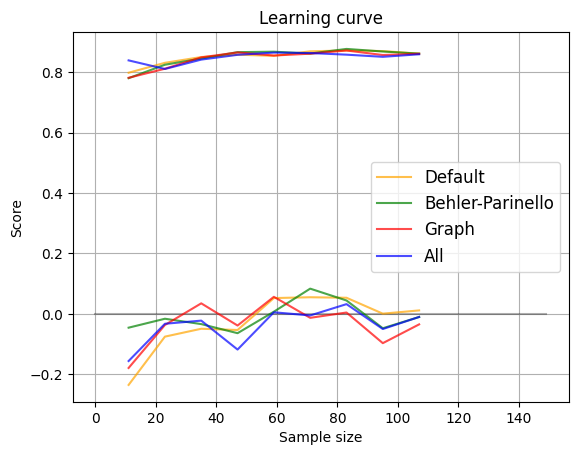

,mean,std
Default,-18.069115,5.584539
Behler-Parinello,-17.585683,8.473984
Graph,-16.646234,7.975136
All,-16.793408,8.680906


In [94]:
fig, ax = plt.subplots()
ax.grid()
plt.plot([0, len(df4)], [0, 0], color = 'black', alpha = 0.3)

train_size_abs, train_scores, test_scores = Default
plt.plot(train_size_abs, train_scores.mean(axis = 1), color = 'orange', label=r'Default', linewidth = 1.5, alpha = 0.7)
plt.plot(train_size_abs, test_scores.mean(axis = 1), color = 'orange', linewidth = 1.5, alpha = 0.7)

train_size_abs, train_scores, test_scores = Behler_Parinello
plt.plot(train_size_abs, train_scores.mean(axis = 1), color = 'green', label=r'Behler-Parinello', linewidth = 1.5, alpha = 0.7)
plt.plot(train_size_abs, test_scores.mean(axis = 1), color = 'green', linewidth = 1.5, alpha = 0.7)

train_size_abs, train_scores, test_scores = graph
plt.plot(train_size_abs, train_scores.mean(axis = 1), color = 'red', label=r'Graph', linewidth = 1.5, alpha = 0.7)
plt.plot(train_size_abs, test_scores.mean(axis = 1), color = 'red', linewidth = 1.5, alpha = 0.7)

train_size_abs, train_scores, test_scores = All
plt.plot(train_size_abs, train_scores.mean(axis = 1), color = 'blue', label=r'All', linewidth = 1.5, alpha = 0.7)
plt.plot(train_size_abs, test_scores.mean(axis = 1), color = 'blue', linewidth = 1.5, alpha = 0.7)

ax.set_xlabel('Sample size')
ax.set_ylabel('Score')
plt.title("Learning curve")
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()
#plt.ylim((0, 4))
plt.show()

results = pd.DataFrame([[Default_score.mean(), Default_score.std()], [Behler_Parinello_score.mean(), Behler_Parinello_score.std()], 
                    [graph_score.mean(), graph_score.std()], [All_score.mean(), All_score.std()]], columns=['mean', 'std'])
results.index = ["Default", "Behler-Parinello", "Graph", "All"]
results

In [95]:
def plot_features_scores(model, data, target, column_names, model_type):
    '''Функция для визуализации важности признаков'''
    
    model.fit(data, target)
    
    if model_type == 'rf':
        (pd.DataFrame(data={'score': model['rf'].feature_importances_}, 
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
    elif model_type == 'lr':
        (pd.DataFrame(data={'score': model['lr'].coef_[0]},
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
        
    else:
        raise KeyError('Unknown model_type')

/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


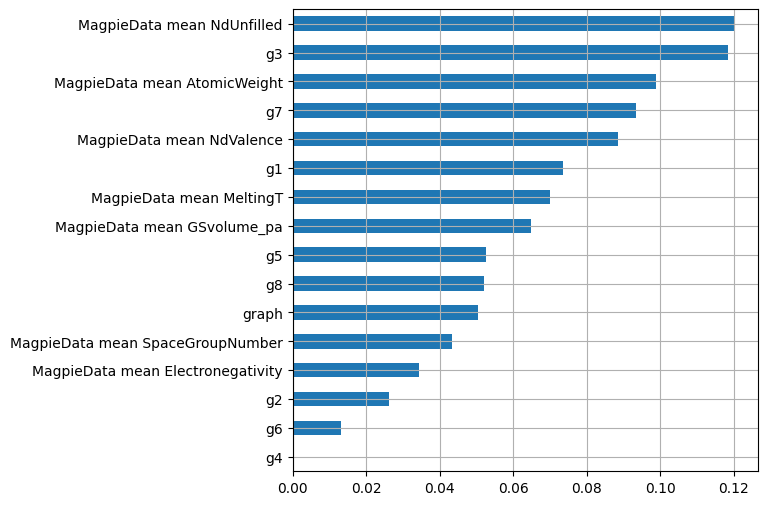

In [102]:
X_train, X_test, y_train, y_test = train_test_split(df4[['MagpieData mean AtomicWeight', 'MagpieData mean MeltingT',
'MagpieData mean Electronegativity', 'MagpieData mean NdValence', 'MagpieData mean GSvolume_pa', 
'MagpieData mean SpaceGroupNumber', 'MagpieData mean NdUnfilled','graph', 'g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8']], data_t4, test_size=0.2, random_state=85)
rf = Pipeline([('rf', rfr1)])
plot_features_scores(model=rf, data=X_test, target=y_test, column_names=X_test.columns, model_type='rf')

11 samples were used to train the model
The average train accuracy is 0.79
The average test accuracy is -0.10

23 samples were used to train the model
The average train accuracy is 0.69
The average test accuracy is -0.11

35 samples were used to train the model
The average train accuracy is 0.78
The average test accuracy is -0.02

47 samples were used to train the model
The average train accuracy is 0.82
The average test accuracy is -0.01

59 samples were used to train the model
The average train accuracy is 0.83
The average test accuracy is 0.01

71 samples were used to train the model
The average train accuracy is 0.81
The average test accuracy is 0.04

83 samples were used to train the model
The average train accuracy is 0.83
The average test accuracy is 0.03

95 samples were used to train the model
The average train accuracy is 0.83
The average test accuracy is 0.04

107 samples were used to train the model
The average train accuracy is 0.82
The average test accuracy is 0.02



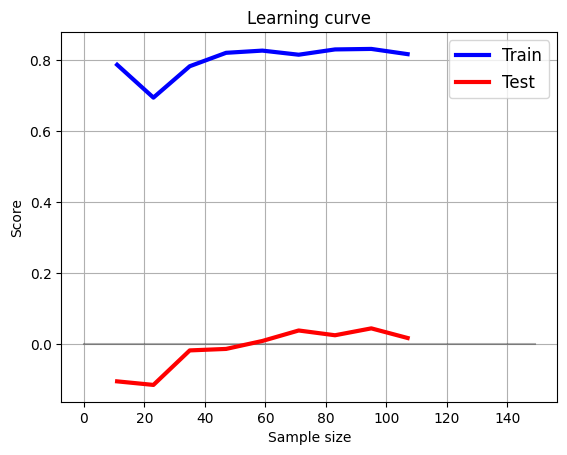

In [35]:
train_size_abs, train_scores, test_scores = learning_curve(rfr1, df4, data_t4.values.ravel(),
                                                           train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

for train_size, cv_train_scores, cv_test_scores in zip(train_size_abs, train_scores, test_scores):
    print(f"{train_size} samples were used to train the model")
    print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
    print(f"The average test accuracy is {cv_test_scores.mean():.2f}")
    print()

fig, ax = plt.subplots()
ax.grid()

plt.plot([0, len(df4)], [0, 0], color = 'black', alpha = 0.3)
plt.plot(train_size_abs, train_scores.mean(axis = 1), color = 'blue', label=r'Train', linewidth = 3)
plt.plot(train_size_abs, test_scores.mean(axis = 1), color = 'red', label=r'Test', linewidth = 3)
ax.set_xlabel('Sample size')
ax.set_ylabel('Score')
plt.title("Learning curve")
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()
#plt.ylim((0, 4))
plt.show()

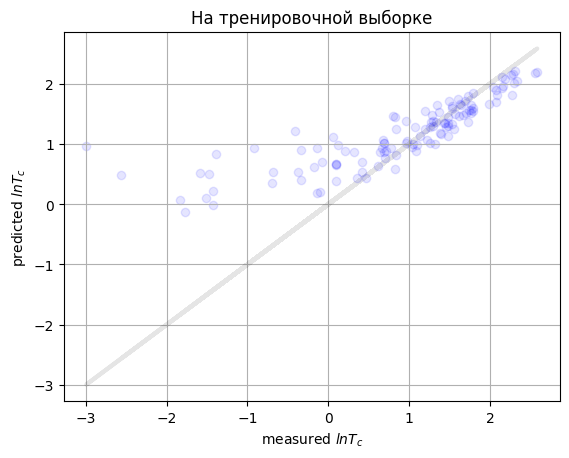

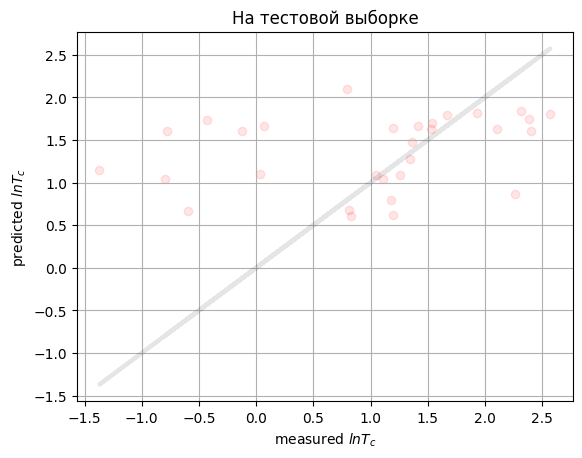

In [36]:
fig, ax = plt.subplots()
ax.grid()


plt.scatter(np.log(y_train), np.log(predictions1), color = 'blue', alpha = 0.1)
plt.plot(np.log(y_train), np.log(y_train), color = 'black', linewidth = 3, alpha = 0.1)
ax.set_xlabel('measured $ln T_c$')
ax.set_ylabel('predicted $ln T_c$')
plt.title("На тренировочной выборке")
#plt.ylim((0, 4))
plt.show()

plt.grid()
plt.scatter(np.log(y_test), np.log(predictions), color = 'red', alpha = 0.1)
plt.plot(np.log(y_test), np.log(y_test), color = 'black', linewidth = 3, alpha = 0.1)
plt.xlabel('measured $ln T_c$')
plt.ylabel('predicted $ln T_c$')
plt.title("На тестовой выборке")
#plt.ylim((0, 4))
plt.show()